In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mygrad.components as mc
import mygrad.functional as mf
from mygrad.losses import BinaryCrossEntropy, CategorialCorssEntropy
from mygrad.optimizers import SGD , RMSProp, Adam
from mygrad.preprocessors import MinMaxScaler, StandardScaler
from mygrad.trainers import BinaryClassificationTrainer, CategoricalClassificationTrainer, ProgressBar, EarlyStopping
from mygrad.dataloaders import NumpyRegressionDataloader, NumpyClassificationDataloader

# XOR 3

In [17]:
train_df = pd.read_csv("../mio1/classification/xor3-training.csv")
test_df = pd.read_csv("../mio1/classification/xor3-test.csv")

In [18]:
train_df.head()

,x,y,c
0,-5.720316,18.198653,0
1,50.039419,-71.390360,0
2,93.072781,-76.340256,0
3,10.434100,-21.863272,0
4,30.198218,-24.730234,0


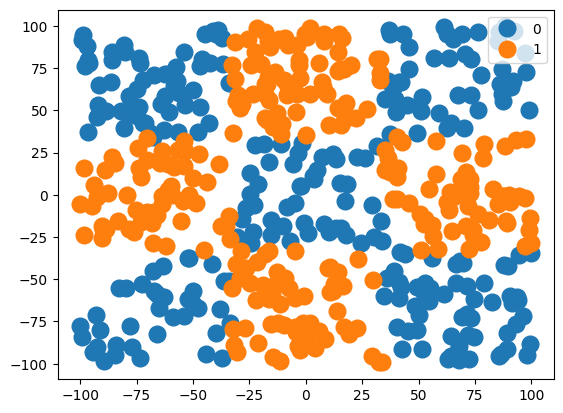

In [19]:
groups = train_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend(loc="upper right")

In [20]:
X_train = train_df[["x", "y"]].values
y_train = train_df["c"].values.reshape(-1, 1) * 1

In [21]:
np.unique(y_train)

array([0, 1])

In [22]:
X_train.shape, y_train.shape

((500, 2), (500, 1))

In [23]:
input_normalizer = StandardScaler()

X_train_scaled = input_normalizer.fit_transform(X_train)

In [24]:
X_test = test_df[["x", "y"]].values
X_test_scaled = input_normalizer.transform(X_test)
y_test = test_df["c"].values.reshape(-1, 1) * 1

## Sigmoid

In [25]:
model = mc.Sequential(
    mc.Linear(2, 10, init="xavier"),
    mc.ReLU(),
    mc.Linear(10, 10, init="xavier"),
    mc.ReLU(),
    mc.Linear(10, 1, init="uniform"),
    mc.Sigmoid(),
)
optimizer = RMSProp(model.parameters(), learning_rate=0.001)
loss = BinaryCrossEntropy()

train_dataloader = NumpyRegressionDataloader(X_train_scaled, y_train, batch_size=20, shuffle=True)
validation_dataloader = NumpyRegressionDataloader(X_test_scaled, y_test, batch_size=100)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=200, metric="fscore", mode="max")
])
train_outputs = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 869


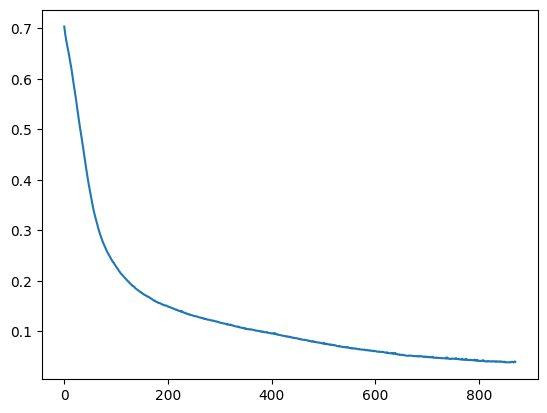

In [28]:
plt.plot(train_outputs["loss"])

In [12]:
y_pred_scaled = model.forward(X_test_scaled)
y_pred = (y_pred_scaled > 0.5) * 1

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.8942676816969224


## Softmax

In [29]:
y_train_onehot = mf.onehot_encode(y_train, 2)
y_test_onehot = mf.onehot_encode(y_test, 2)

In [30]:
model = mc.Sequential(
    mc.Linear(2, 10, init="xavier"),
    mc.ReLU(),
    mc.Linear(10, 10, init="xavier"),
    mc.ReLU(),
    mc.Linear(10, 2, init="uniform"),
    mc.Softmax(),
)
optimizer = Adam(model.parameters(), learning_rate=0.001)
loss = CategorialCorssEntropy()

train_dataloader = NumpyClassificationDataloader(X_train_scaled, y_train_onehot, batch_size=20, shuffle=True, is_one_hot=True)
validation_dataloader = NumpyClassificationDataloader(X_test_scaled, y_test_onehot, batch_size=100, is_one_hot=True)
trainer = BinaryClassificationTrainer(model, optimizer, loss, train_dataloader, validation_dataloader, plugins=[
    ProgressBar(),
    EarlyStopping(patience=200, metric="fscore", mode="max")
])
train_outputs = trainer.train(5000)

Training epochs:   0%|          | 0/5000 [00:00<?, ?it/s]

Early stopping at epoch 535


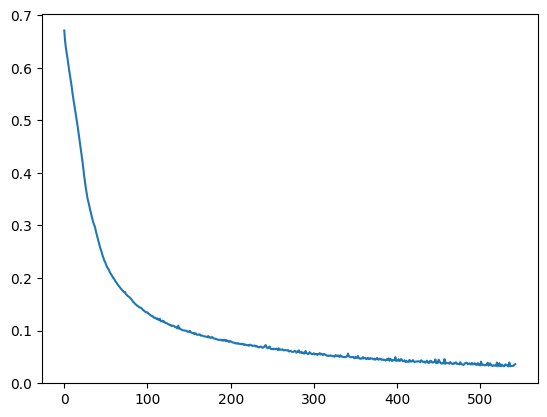

In [15]:
plt.plot(train_outputs["loss"])

In [16]:
y_pred_scaled = model.forward(X_test_scaled)
y_pred = np.argmax(y_pred_scaled, axis=1)

print(f"F-score: {mf.fscore(y_pred, y_test, 2)}")


F-score: 0.9350649350649352


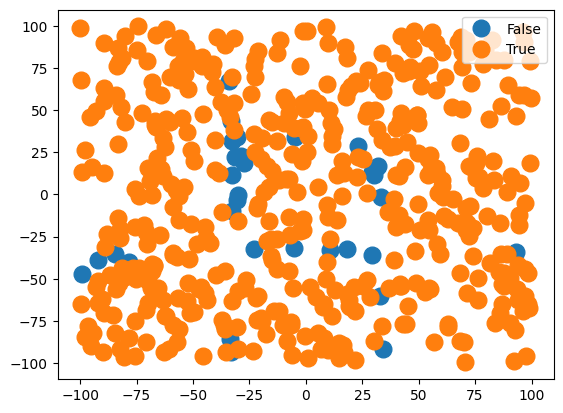

In [17]:
pred_test_df = pd.DataFrame({
    "x": X_test[:, 0],
    "y": X_test[:, 1],
    "c": y_pred == y_test.reshape(-1)
})
groups = pred_test_df.groupby('c')
for name, group in groups:
    plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)

plt.legend(loc="upper right")

In [18]:
print(model)

Sequential(
	Linear(input_size=2, output_size=10, init=xavier),
	ReLU(),
	Linear(input_size=10, output_size=10, init=xavier),
	ReLU(),
	Linear(input_size=10, output_size=2, init=uniform),
	Softmax()
)
